In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [2]:
def parse_image(img_path, image_size):
    image_rgb = cv2.imread(img_path, 1)
    h, w, _ = image_rgb.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        image_rgb = cv2.resize(image_rgb, (image_size, image_size))
    image_rgb = image_rgb/255.0
    return image_rgb

def parse_mask(mask_path, image_size):
    mask = cv2.imread(mask_path, -1)
    h, w = mask.shape
    if (h == image_size) and (w == image_size):
        pass
    else:
        mask = cv2.resize(mask, (image_size, image_size))
    mask = np.expand_dims(mask, -1)
    mask = mask/255.0

    return mask


In [3]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            ## Read image and mask
            image = parse_image(images_path[i], self.image_size)
            mask = parse_mask(masks_path[i], self.image_size)

            images_batch.append(image)
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))


### m_resunet

In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [5]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul


In [6]:
class ResUnetPlusPlus:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(1, (1, 1), padding="same")(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model


In [7]:
# metrics.py

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [10]:
# import os
# os.mkdir("/content/files")

In [11]:
from glob import glob
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [13]:
# Path
file_path = "./files/"
model_path = "./files/resunetplusplus.h5"

# Create files folder
try:
    os.mkdir("files")
except:
    pass

train_path = "../input/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/train/"
valid_path = "../input/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/valid/"

# Training
train_image_paths = glob(os.path.join(train_path, "images", "*"))
train_mask_paths = glob(os.path.join(train_path, "masks", "*"))
train_image_paths.sort()
train_mask_paths.sort()

# Validation
valid_image_paths = glob(os.path.join(valid_path, "images", "*"))
valid_mask_paths = glob(os.path.join(valid_path, "masks", "*"))
valid_image_paths.sort()
valid_mask_paths.sort()

# Parameters
image_size = 256
batch_size = 8
lr = 1e-4
epochs = 10

train_steps = len(train_image_paths)//batch_size
valid_steps = len(valid_image_paths)//batch_size

# Generator
train_gen = DataGen(image_size, train_image_paths, train_mask_paths, batch_size=batch_size)
valid_gen = DataGen(image_size, valid_image_paths, valid_mask_paths, batch_size=batch_size)

# ResUnet++
arch = ResUnetPlusPlus(input_size=image_size)
model = arch.build_model()

optimizer = tf.keras.optimizers.Nadam(lr)
metrics = [Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

csv_logger = CSVLogger(f"{file_path}unet_{batch_size}.csv", append=False)
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
callbacks = [csv_logger, checkpoint, reduce_lr, early_stopping]

model.fit_generator(train_gen,
        validation_data=valid_gen,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks)


Epoch 1/10
3100/3100 [==============================] - 766s 242ms/step - loss: 0.5036 - recall_1: 0.6467 - precision_1: 0.4669 - dice_coef: 0.4964 - mean_io_u_1: 0.5608 - val_loss: 0.3987 - val_recall_1: 0.6248 - val_precision_1: 0.6052 - val_dice_coef: 0.6013 - val_mean_io_u_1: 0.6357

Epoch 00001: val_loss improved from inf to 0.39865, saving model to ./files/resunetplusplus.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
3100/3100 [==============================] - 750s 242ms/step - loss: 0.4200 - recall_1: 0.6411 - precision_1: 0.5894 - dice_coef: 0.5800 - mean_io_u_1: 0.6144 - val_loss: 0.2633 - val_recall_1: 0.6908 - val_precision_1: 0.7811 - val_dice_coef: 0.7367 - val_mean_io_u_1: 0.6818

Epoch 00002: val_loss improved from 0.39865 to 0.26333, saving model to ./files/resunetplusplus.h5
Epoch 3/10
3100/3100 [==============================] - 749s 242ms/step - loss: 0.3435 - recall_1: 0.6802 - precision_1: 0.6736 - dice_coef: 0.6565 - mean_io_u_1: 0.6654 - val_loss: 0.2590 - val_recall_1: 0.7238 - val_precision_1: 0.7509 - val_dice_coef: 0.7410 - val_mean_io_u_1: 0.7203

Epoch 00003: val_loss improved from 0.26333 to 0.25902, saving model to ./files/resunetplusplus.h5
Epoch 4/10
3100/3100 [==============================] - 750s 242ms/step - loss: 0.2806 - recall_1: 0.7146 - precision_1: 0.7468 - dice_coef: 0.7194 - mean_io_u_1: 0.7133 - val_loss: 0.2547 - val_recall_1: 0.5826 - val_precis

In [16]:
import pandas as pd
data = pd.read_csv("./files/unet_8.csv")

In [19]:
data

,epoch,dice_coef,loss,mean_io_u_1,precision_1,recall_1,val_dice_coef,val_loss,val_mean_io_u_1,val_precision_1,val_recall_1
0,0,0.496378,0.503622,0.560780,0.466922,0.646740,0.601345,0.398655,0.635691,0.605193,0.624773
1,1,0.579958,0.420043,0.614365,0.589427,0.641135,0.736670,0.263330,0.681821,0.781070,0.690771
2,2,0.656524,0.343475,0.665438,0.673561,0.680155,0.740983,0.259017,0.720260,0.750853,0.723835
3,3,0.719399,0.280601,0.713270,0.746774,0.714617,0.745321,0.254679,0.670062,0.914815,0.582606
4,4,0.763180,0.236820,0.748045,0.792043,0.745238,0.810800,0.189200,0.759548,0.867235,0.732158
5,5,0.798369,0.201631,0.776415,0.827848,0.772305,0.820613,0.179387,0.754372,0.949149,0.674941
6,6,0.821907,0.178095,0.795745,0.854083,0.786260,0.835947,0.164053,0.769639,0.925375,0.707947
7,7,0.843881,0.156117,0.814958,0.873667,0.804673,0.719254,0.280746,0.658076,0.931170,0.555129
8,8,0.856499,0.143500,0.828024,0.888791,0.814092,0.807702,0.192298,0.765241,0.929640,0.662900
9,9,0.871994,0.128006,0.841533,0.899146,0.828571,0.840761,0.159239,0.797830,0.891973,0.757419


In [25]:
import matplotlib.pyplot as plt

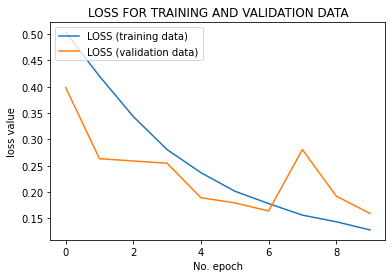

In [26]:
# Plot history: MAE
plt.plot(data['loss'], label='LOSS (training data)')
plt.plot(data['val_loss'], label='LOSS (validation data)')
plt.title('LOSS FOR TRAINING AND VALIDATION DATA')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

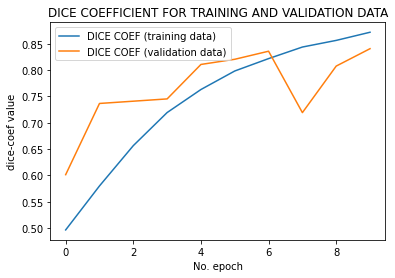

In [27]:
# Plot history: MAE
plt.plot(data.dice_coef, label='DICE COEF (training data)')
plt.plot(data.val_dice_coef, label='DICE COEF (validation data)')
plt.title('DICE COEFFICIENT FOR TRAINING AND VALIDATION DATA')
plt.ylabel('dice-coef value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

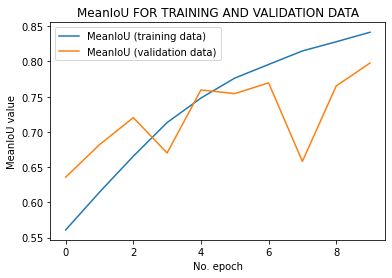

In [28]:
# Plot history: MAE
plt.plot(data.mean_io_u_1, label='MeanIoU (training data)')
plt.plot(data.val_mean_io_u_1, label='MeanIoU (validation data)')
plt.title('MeanIoU FOR TRAINING AND VALIDATION DATA')
plt.ylabel('MeanIoU value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

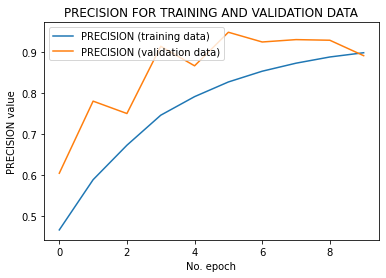

In [29]:
# Plot history: MAE
plt.plot(data.precision_1, label='PRECISION (training data)')
plt.plot(data.val_precision_1, label='PRECISION (validation data)')
plt.title('PRECISION FOR TRAINING AND VALIDATION DATA')
plt.ylabel('PRECISION value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

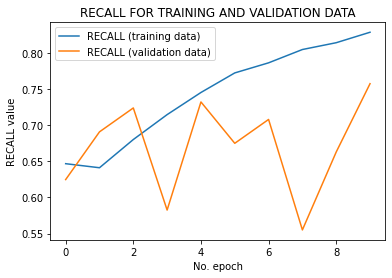

In [30]:
# Plot history: MAE
plt.plot(data.recall_1, label='RECALL (training data)')
plt.plot(data.val_recall_1, label='RECALL (validation data)')
plt.title('RECALL FOR TRAINING AND VALIDATION DATA')
plt.ylabel('RECALL value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [20]:
def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [21]:
os.mkdir("./result")

In [23]:
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope

In [24]:
model_path = "./files/resunetplusplus.h5"
save_path = "./result"
test_path = "../input/kvasit-seg-train-test-valid/content/new_data/Kvasir-SEG/test"

image_size = 256
batch_size = 1

test_image_paths = glob(os.path.join(test_path, "images", "*"))
test_mask_paths = glob(os.path.join(test_path, "masks", "*"))
test_image_paths.sort()
test_mask_paths.sort()

## Create result folder
try:
    os.mkdir(save_path)
except:
    pass

## Model
with CustomObjectScope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
    model = load_model(model_path)

## Test
print("Test Result: ")
test_steps = len(test_image_paths)//batch_size
test_gen = DataGen(image_size, test_image_paths, test_mask_paths, batch_size=batch_size)
model.evaluate_generator(test_gen, steps=test_steps, verbose=1)

## Generating the result
for i, path in tqdm(enumerate(test_image_paths), total=len(test_image_paths)):
    image = parse_image(test_image_paths[i], image_size)
    mask = parse_mask(test_mask_paths[i], image_size)

    predict_mask = model.predict(np.expand_dims(image, axis=0))[0]
    predict_mask = (predict_mask > 0.5) * 255.0

    sep_line = np.ones((image_size, 10, 3)) * 255

    mask = mask_to_3d(mask)
    predict_mask = mask_to_3d(predict_mask)

    all_images = [image * 255, sep_line, mask * 255, sep_line, predict_mask]
    cv2.imwrite(f"{save_path}/{i}.png", np.concatenate(all_images, axis=1))

print("Test image generation complete")


Test Result: 


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


100/100 [==============================] - 5s 29ms/step - loss: 0.2374 - recall_1: 0.6529 - precision_1: 0.8694 - dice_coef: 0.7626 - mean_io_u_1: 0.7323


100%|██████████| 100/100 [00:09<00:00, 10.83it/s]

Test image generation complete
